<center><h1>Mjerenja u bežičnim sustavima (221, 222, 241, 242)</h1></center>
<center>~ Akademska godina 2020/2021 ~</center>
<center>Ante Lojić Kapetanović</center>
<center>Fakultet elektrotehnike, strojastva i brodogradnje</center>
<center>Sveučilište u Splitu</center>
<center>Split, Hrvatska</center>
<hr />

**Pregled** $-$ Kroz ove laboratorijske vježbe bavit ćemo se analizom vremenskih promjena značajki radio kanala pri komunikaciji na ultra visokim frekvencijama (*Ultra High Frequencies*, UHF) i super visokim frekvencijama (*Super High Frequencies*, SHF) u zatvorenim prostorima. Sve bitne značajke radiokomunikacije između predajnika signala (*Signal Hound VSG25A USB Vector Signal Generator*, omnidirekcijska antena) i prijemnika signala (*BB60C - 6GHz Real-time Spectrum Analyzer*, omnidirekcijska antena) pratit ćemo na prijemnoj strani. Nakon prikupljanja relevantnih podataka, podatke ćemo *očistiti* i obraditi za daljnju analizu. Odredit ćemo konstantu propagacije radio valova te statističku distribuciju kanala.
<hr />

In [1]:
import datetime as dt
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rice

rootdir = os.path.abspath(os.path.join(os.pardir))
DATASET_PATH = os.path.join(rootdir, 'lab', 'data')

## Demonstracija mjerenja u praksi
Primjer: https://ieeexplore.ieee.org/document/8783058

### Prikupljanje podataka o snazi signala na prijemnoj strani
Za demonstraciju, prije početka stvarnih mjerenja komercijalnim programskim paketima navedenima na početku dokumenta, dan je primjer mjerenja kanala koristeći Linux ugrađene alate koji ostvaruju komunikaciju s bežičnom mrežnom karticom u računalu i na taj način mjere (procjenjuju) snagu primljenog signala pri čemu je predajnik pristupna točka s kojom je računalo povezano. 

Korišteni alati za mjerenje:
* `iw` -- praćenje stanja na kanalu u realnom vremenu
* `nl80211` -- `C`-*header* koji služi kao *firmware* za bežičnu mrežnu karticu u računalu
* `Python 3.x.x` -- automatizacija prikupljanja podataka

Primjer skripte:
```python
from datetime import datetime
from subprocess import call as pcall


num_of_readings = 20
time_span = 5
with open('starttime.txt', mode='w') as file:
    file.write(f'Measuring start time: {datetime.now()}\n')
for m in range(n_of_readings):
    pcall('iw wlo1 info | grep channel | cut -d " " -f 2  | tee -a channel_tx.txt', shell=True)
    pcall('iw wlo1 info | grep channel | cut -d " " -f 9 | tee -a freq_tx.txt', shell=True)
    pcall('iwconfig wlo1 | grep Signal | cut -d "-" -f 2 | cut -d " " -f 1 | tee -a power_rx.txt', shell=True)
    time.sleep(time_span)
```

### Pregled podataka
Prostor na kojem se odvijalo mjerenje prikazan je na slici:

<img src='static/measuring-points-layout.png' alt='Measuring layout' width='500' height='600'>

Prostor je ograđen je s $4$ nosiva zida, dok su ostali unutarnji zidovi od opeke i šuplji te signal ne trpi preveliku atenuaciju na svom putu do prijemnika.
Sva vrata izrađena su od hrastovog drva s blago sjajnom površinom, a prozori s dvostrukim zastakljenjima bili su zatvoreni dok su metalni kapci bili otvoreni tijekom provedbe mjerenja. Visina stropa je $2.3$ m.

Mjerenje je provedeno na pet točaka gore opisanog prostora, gdje je položaj prijamnika označen brojevima od 1 do 5, dok je predajnik označen trokutnim antenskim simbolom. Predajna antena postavljena je na visinu od $1.05$ m iznad poda, dok su prijemne antene postavljene na relativnim visinama od poda u iznosu od $0.80$ m na položaju 1, $0.70$ m na položaju 2, $0.50$ m na položaju 3, $0.90$ m na položaju 4 i $0.00$ m na položaju 5.

### Obrada mjerenih podataka
Kako bi izbjegli potencijalne probleme u kasnijoj analizi, podaci su očišćeni od pogrešno mjerenih vrijednosti. U primjeru su podaci mjereni kroz ukupno 5 dana, na svakoj mjernoj točki mjerenje je trajalo po 24 sata s razmakom pojedinih mjerenja od 6 sekundi koristeći `Python` skriptu prikazanu poviše.

### Komunikacijski kanal
Osim viševalne prirode primljene snage na promatranim mjernim točkama, prijemna strana je podvrgnuta vremenskim promjenama radio kanala uzrokovana šumom i brojnim drugim negativnim faktorima (kretanje osoba, mijenjanje atmosferskih prilika...). Potrebno je, dakle, kreirati statističku karakterizaciju vremenski promjenjivog WiFi kanala na temelju mjerenja kroz relativno duge vremenske intervale unutar prikazanog mjernog prostora.

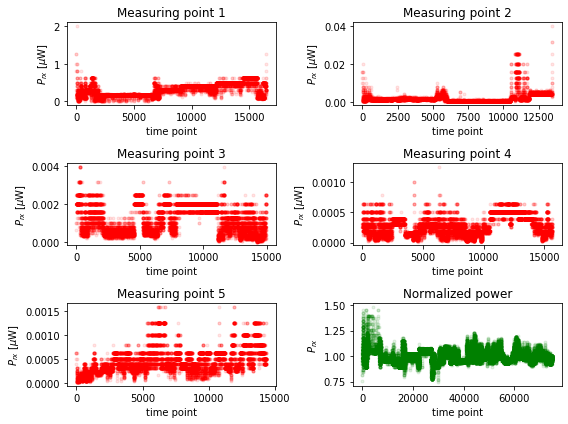

In [2]:
def convert_to_watts(p_rx):
    return np.power(10,((p_rx-30)/10))


p_rx_list = [
    -np.loadtxt(os.path.join(DATASET_PATH, 'clean', 'power_rx1.txt')),
    -np.loadtxt(os.path.join(DATASET_PATH, 'clean', 'power_rx2.txt')),
    -np.loadtxt(os.path.join(DATASET_PATH, 'clean', 'power_rx3.txt')),
    -np.loadtxt(os.path.join(DATASET_PATH, 'clean', 'power_rx4.txt')),
    -np.loadtxt(os.path.join(DATASET_PATH, 'clean', 'power_rx5.txt'))]

p_rx_norm_list = []
p_rx_w_list = []
p_rx_w_norm_list = []
for p_rx in p_rx_list:
    p_rx_norm_list.extend(p_rx / np.mean(p_rx))
    p_rx_w = convert_to_watts(p_rx)
    p_rx_w_list.append(p_rx_w)
    p_rx_w_norm_list.extend(p_rx_w / np.mean(p_rx_w))

idx_mp = 0
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6))
for idx_row in range(3):
    for idx_col in range(2):
        if idx_mp < 5:
            ax[idx_row][idx_col].plot(p_rx_w_list[idx_mp]*10**6, 'r.', alpha=0.1)
            ax[idx_row][idx_col].set_xlabel('time point')
            ax[idx_row][idx_col].set_ylabel('$P_{rx}$ [$\\mu$W]')
            ax[idx_row][idx_col].set_title(f'Measuring point {idx_mp+1}')
        else:
            ax[idx_row][idx_col].plot(p_rx_norm_list, 'g.', alpha=0.1)
            ax[idx_row][idx_col].set_xlabel('time point')
            ax[idx_row][idx_col].set_ylabel('$P_{rx}$')
            ax[idx_row][idx_col].set_title(f'Normalized power')
        idx_mp += 1
plt.tight_layout()
plt.show()

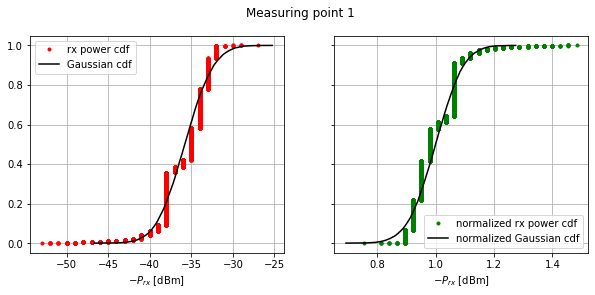

In [3]:
def ecdf(p_rx):
    n = len(p_rx)
    x = np.sort(p_rx)
    y = np.arange(1, n+1) / n
    return x, y


mp = 1
x_emp, cdf_emp = ecdf(p_rx_list[mp-1])
x_gaussian, cdf_gaussian = ecdf(np.random.normal(np.mean(p_rx_list[mp-1]), np.std(p_rx_list[mp-1]), x_emp.size))
x_emp_norm, cdf_emp_norm = ecdf(p_rx_list[mp-1]/np.mean(p_rx_list[mp-1]))
x_gaussian_norm, cdf_gaussian_norm = ecdf(np.random.normal(np.mean(p_rx_list[mp-1]/np.mean(p_rx_list[mp-1])), np.std(p_rx_list[mp-1]/np.mean(p_rx_list[mp-1])), x_emp_norm.size))

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))
ax[0].plot(x_emp, cdf_emp, 'r.', label='rx power cdf')
ax[0].plot(x_gaussian, cdf_gaussian, 'k-', label='Gaussian cdf')
ax[0].set_xlabel('$ - P_{rx}$ [dBm]')
ax[0].legend()
ax[0].grid()
ax[1].plot(x_emp_norm, cdf_emp_norm, 'g.', label='normalized rx power cdf')
ax[1].plot(x_gaussian_norm, cdf_gaussian_norm, 'k-', label='normalized Gaussian cdf')
ax[1].set_xlabel('$ - P_{rx}$ [dBm]')
ax[1].legend()
ax[1].grid()
fig.suptitle(f'Measuring point {mp}')
plt.show()

/home/alk/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


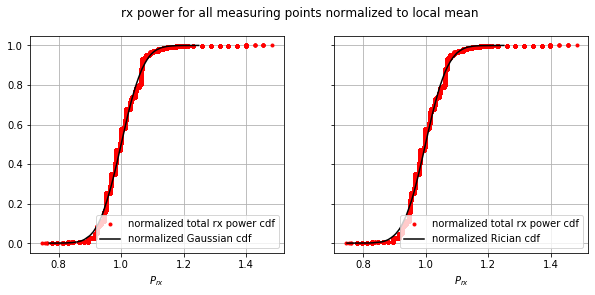

In [4]:
x_total_emp, cdf_total_emp = ecdf(p_rx_norm_list)
x_total_gaussian, cdf_total_gaussian = ecdf(np.random.normal(np.mean(p_rx_norm_list), np.std(p_rx_norm_list), x_total_emp.size))

b, loc, scale = rice.fit(p_rx_norm_list)
rice_rvs = rice.rvs(b, loc, scale, size=x_total_emp.size)
x_total_rician, cdf_total_rician = ecdf(rice_rvs)


fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))
ax[0].plot(x_total_emp, cdf_total_emp, 'r.', label='normalized total rx power cdf')
ax[0].plot(x_total_gaussian, cdf_total_gaussian, 'k-', label='normalized Gaussian cdf')
ax[0].set_xlabel('$P_{rx}$')
ax[0].legend()
ax[0].grid()
ax[1].plot(x_total_emp, cdf_total_emp, 'r.', label='normalized total rx power cdf')
ax[1].plot(x_total_rician, cdf_total_rician, 'k-', label='normalized Rician cdf')
ax[1].set_xlabel('$P_{rx}$')
ax[1].legend()
ax[1].grid()
fig.suptitle('rx power for all measuring points normalized to local mean')
plt.show()

### Izračun gubitaka kanala

Primljena snaga singala $P_{rx}$ može se zapisati kao:

\begin{equation}
    P_{Rx} = \frac{P_{eirp} G_{rx}}{L_{f.s.}L_{ex}}
    \label{eq.P_mean}
\end{equation}

gdje je $P_{eirp}$ efektivna snaga izotropnog radijatora,  $G_{rx}$ je *gain* prijemnika, $L_{f.s.}$ je gubitak u slobodnom prostoru definiran kroz Friisovu jednadžbu i $L_{ex}$ predstavlja sve dodatne gubitake.

S obzirom na odnos $L_{f.s.} \sim d^2$, očekuje se da će s porastom kvadrata udaljenosti ukupni gubitci slobodnog prostora biti veći a ukupna snaga na prijemu će biti manja. Za realne uvjete govorimo o zakonu opadanja prijemne snage s obzirom na udaljenost $d$ od predajnika: $P_{rx} \sim 1/d^n$, pri čemu je $n$ koeficijent gubitaka realnog prostora koji ovisi o konfiguraciji istog.

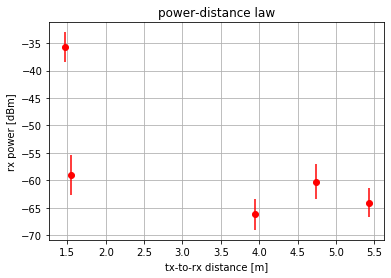

In [5]:
distances = [1.4637, 1.5435, 4.7363, 3.9455, 5.4288]
p_rx_localized_mean = []
p_rx_localized_err = []
for p_rx in p_rx_list:
    p_rx_localized_mean.append(np.mean(p_rx))
    p_rx_localized_err.append(np.std(p_rx))
plt.errorbar(distances, p_rx_localized_mean, p_rx_localized_err, marker='o', linestyle='None', color='r')
plt.xlabel('tx-to-rx distance [m]')
plt.ylabel('rx power [dBm]')
plt.title('power-distance law')
plt.grid()
plt.show()

Gubitci u realnim uvjetima dani su kroz koeficijent $n$ kojeg dobijemo tako što izračunamo nagib pravca koji predstavlja trend opadanja snage s obzirom na udaljenost predajnika i prijemnika za stvarna mjerenja.

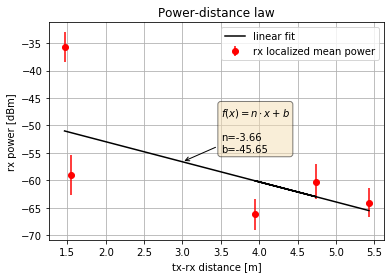

In [6]:
popt = np.polyfit(distances, p_rx_localized_mean, w=[sigma for sigma in p_rx_localized_err], deg=1)
fit = np.poly1d(popt) 

plt.errorbar(distances, p_rx_localized_mean, p_rx_localized_err, linestyle='None', marker='o', color='r', label='rx localized mean power')
plt.plot(distances, fit(distances), 'k-', label='linear fit')
plt.annotate(f'$f(x) = n \\cdot x + b$\n\nn={round(popt[0], 2)}\nb={round(popt[1], 2)}', xy=(3.0, fit(3.0)), xytext=(3.5, fit(3.5)+12), verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), arrowprops=dict(arrowstyle="->"))
plt.xlabel('tx-rx distance [m]')
plt.ylabel('rx power [dBm]')
plt.legend()
plt.title('Power-distance law')
plt.grid()
plt.show()

Proračun koristeći komercijalni paket `Wireless InSite` daje veću primljenu snagu u usporedbi s izmjerenim -- to ukazuje na važnost dodatnih prepreka signalu koji nisu uključeni u simulaciju, ali obično se nalaze u stambenim apartmanima (vodljive plohe, elektronički uređaji, dinamika ljudi u prostoru itd.)

<img src='static/wireless-insite.png' alt='Wireless insite model' width='500' height='600'>

Koeficijent propagacije za slobodni prostor dan je kroz izraz:
$$ n_{FS} = \left(\frac{4πdf}{c}\right)^{2} $$

gdje je $d$ udaljenost između prijemnika i predajnika, $f$ je frekvencija, a $c$ je brzina elektromagnetskog vala.
Budući da su gubici definirani kroz dBm, prethodni izraz je potrebno prilagoditi:

$$ 
\begin{align}
n_{FS}(\text{dB})
  &= 10\log_{10}\left(\left(\frac{4\pi d f}{c}\right)^2\right) \\
  &= 20\log_{10}\left(\frac{4\pi d f}{c}\right)  \\
  &= 20\log_{10}(d) + 20\log_{10}(f) + 20\log_{10}\left(\frac{4\pi}{c}\right) \\
  &= 20\log_{10}(d) + 20\log_{10}(f) - 147.55
\end{align}
$$

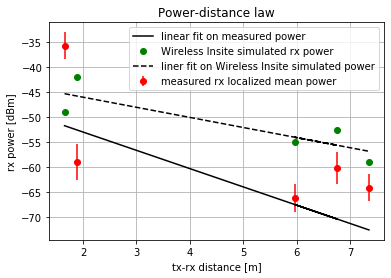

[emprical] n = 3.657807869309304
[simulated] n = 2.0215854372861894


In [7]:
wireless_insite_p_rx_localized = np.array([-49.0, -42.0, -52.5, -55.0, -59.0])
log_distances = 10 * np.log10(distances)
popt_wi = np.polyfit(log_distances, wireless_insite_p_rx_localized, deg=1)
fit_wi = np.poly1d(popt_wi) 

plt.errorbar(log_distances, p_rx_localized_mean, p_rx_localized_err, linestyle='None', marker='o', color='r', label='measured rx localized mean power')
plt.plot(log_distances, fit(log_distances), 'k-', label='linear fit on measured power')
plt.plot(log_distances, wireless_insite_p_rx_localized, 'go', label = 'Wireless Insite simulated rx power')
plt.plot(log_distances, fit_wi(log_distances), 'k--', label='liner fit on Wireless Insite simulated power')
plt.xlabel('tx-rx distance [m]')
plt.ylabel('rx power [dBm]')
plt.legend()
plt.title('Power-distance law')
plt.grid()
plt.show()

print(f'[emprical] n = {np.abs(popt[0])}')
print(f'[simulated] n = {np.abs(popt_wi[0])}')

### Izračun gubitaka snage

Ukupni gubici računaju se preko izraza:

$$ a_{f.s.} [\mbox{dB}] = 32.5 + 20 \cdot \log{f [\mbox{MHz}]} + 20 \cdot \log{d [\mbox{km}]} - G_{tx} [\mbox{dBi}] - G_{rx} [\mbox{dBi}]$$

gdje je $f$ frekvencija kanala, $d$ udaljenost između prijemnika i predajnika te $G_{Tx}$ i $G_{Rx}$ dobitci predajnika i prijemnika. 

Stvarne gubitke tijekom mjerenja je jednostavno izračunati preko izraza:

$$ a = P_{tx} - P_{rx} $$

gdje je $P_{tx}$ snaga signala na izlazu iz predajnika, a $P_{rx}$ je primljena snaga na prijemniku.

Ako se za istu frekvenciju i udaljenost između prijemnika i predajnika provede veći broj mjerenja, potrebno je takva mjerenja usrednjiti prije uvrštavanja u prethodno dani izraz. Osim toga, potrebno je definirati i stupanj pouzdanosti mjerenja eksplicitno navodeći moguću pogrešku. 

In [8]:
f = 2450
p_tx = 10
G_tx = G_rx = 0.725
n = np.abs(popt[0])
d = np.asarray(distances, dtype=np.float32)

a_fs = 32.5 + (n*10*np.log10(f)) + (n*10*np.log10(d/1000)) - (G_tx + G_rx)
a_emp = p_tx - np.asarray(p_rx_localized_mean)

print(f'Free space loss approximation: {a_fs}')
print(f'Experimental loss: {a_emp}')

Free space loss approximation: [51.336857 52.18015  69.99121  67.08921  72.159   ]
Experimental loss: [45.74055171 69.02406596 70.22415982 76.17063669 74.08733533]
